<a href="https://colab.research.google.com/github/Formulator/Spiral/blob/master/PyTorch_Spiral_DataLoader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PyTorch Spiral DataLoader

## This notebook is a demonstration of workflow for  big-data handling in PyTorch.

The PyTorch [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) class is a mechanism to serve batches of data to a machine learning agent.  It can be arranged to work with data already in memory but also to serve data from disk on-the-fly.

When a sizeable data set will not fit into RAM the DataLoader class offers a solution by drawing manageable batches from disk.  This is accomplished in parallel by multiple workers thereby keeping a demanding GPU supplied with mini-batches of data.

What follows is a small-data exercise using big-data techniques.

This demonstration will:

1.   Create some 2-dimension, three-class data in a spiral form.
2.   Store the data to disk. Where each file represents an INDIVIDUAL sample and also contains the class-label.
2.   From disk get the file NAMES and allocate by NAME into 'training' or 'validation' groups.  The files do not move.
3.   Configure a DataLoader to prepare and serve mini-batches of data to a PyTorch machine learning network.
4.   Train a deep neural network to accurately classify the data.
5.   Plot the evolution of the decision boundaries, loss and accuracy.

# Create and plot the data.....

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(-1.5, 1.5)

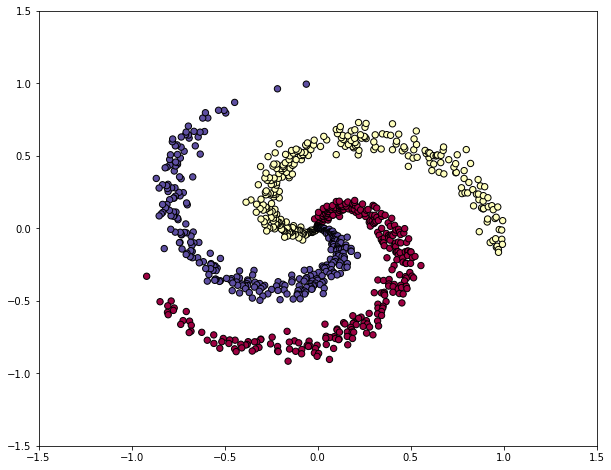

In [53]:
# A bit of setup
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

np.random.seed(0)
N = 300 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D))
y = np.zeros(N*K, dtype='uint8')
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], edgecolors='k', c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])
#fig.savefig('spiral_raw.png')

#print('Features: ' , X[::10])# print every 10th element
#print('Class Labels: ', y[::10])# print every 10th element

# GPU or CPU

This notebook was created on [Google Colaboratory](https://colab.research.google.com/notebooks/welcome.ipynb)

It will automatically detect if the environment offers a GPU and use it.  Otherwise it will run on CPU, which turns out to be faster in this case.


In [54]:
import torch

#GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 0:
    print("Running on : ", torch.cuda.device_count(), " GPUs!"
          if torch.cuda.device_count() > 1 else " GPU!")
else:
    print("Running on CPU!")

Running on CPU!


# Prepare folder

Just make a folder in the current working directory

In [55]:
import os
from os import path

# create the data directory
print('Current working directory: ', os.getcwd())
if os.path.exists('data'):
  import shutil
  shutil.rmtree('data')
  print('Removed previously created data directory & contents') 

os.mkdir('data')
print('New data directory created')

print(os.listdir())

Current working directory:  /content
Removed previously created data directory & contents
New data directory created
['.config', 'data', 'sample_data']


# Serialise PyTorch tensors to disk

Each sample goes into it's own file with the file names enumerated.

e.g.  id-1.pt, id-2.pt ..... id-n.pt

In [0]:
# Join class labels vector onto features matrix ready for storage
Xy = np.block([[X, np.reshape(y, (len(y), 1))]])

# Method to store each sample under an enumerated file name
def store_as_torch_tensor(slc, num):
  pt_array = torch.tensor(slc, dtype=torch.float)
  torch.save(pt_array, 'data/id-{}.pt'.format(num))
  #print(slc.size, 'data/id-{}.pt'.format(num), pt_array)
  return num + 1

# Commence file name enumeration with.... 
ID = 1

# Save to disk
for row in Xy:
  ID = store_as_torch_tensor(row, ID)

# Prepare DataLoader sources

The DataLoader will be passed two Python dictionaries, they are prepared like so:



1.   partition = {'train': ['id-750.pt', 'id-208.pt', 'id-891.pt', etc......], 'validation':['id-474.pt', 'id-5.pt', 'id-525.pt', 'id-858.pt', etc.....]}
2.   labels = {'id-750.pt': 2, 'id-208.pt': 0, 'id-891.pt': 2, 'id-361.pt': 1, 'id-381.pt': 1, etc.....}

The DataLoader will sample from the appropriate 'train' or 'validation' set to build a mini-batch, the associated class-label value will be retrieved from the labels dictionary.




In [57]:
from random import shuffle

# Working with file NAMES of each sample
samples = []
# Walk the 'data' directory
for (dirpath, dirnames, filenames) in os.walk('data'):
  samples = filenames
  
# Shuffle before splitting
shuffle(samples)

# Split dataset by percentage
train = samples[0 : int(len(samples) * .75)]
valid = samples[int(len(samples) * .75) : ]
print('Training   set: ', len(train))  
print('Validation set: ', len(valid))

# Assign sample NAMES to partition dictionary
partition = {'train': train, 'validation' : valid}
#print(partition)

# Assign label VALUES to labels dictionary
labels = {}
for sample in samples:
  sample_tensor = torch.load('data/' + sample)
  labels[sample] = int(sample_tensor[-1].item())
#print(labels)

Training   set:  675
Validation set:  225


# Dataset class

Class method __getitem__ is called for every sample.  Here it has been customised to make some changes before the data reaches the neural network.

When the data was stored to disk the features and labels were combined into one array to ensure they would stay aligned when shuffled.  Here only the feature columns are selected.

The label dictionary is searched using the file name,  the resulting label value is one-hot encoded.

In [0]:
#import torch
from torch.utils import data

class Dataset(data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, list_IDs, labels):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]
        # From file load the data for this sample
        X = torch.load('data/' + ID)
        # Slice off the labels column so that only features are assigned to X
        X = X[:-1]
        # Labels dictionary was loaded into memory earlier; here the
        # file name is used as the key to retrieve the class label value
        y = torch.tensor(self.labels[ID])
        # Apply one-hot encoding to the class label
        y_ohe = torch.nn.functional.one_hot(y , num_classes=3).float()
        
        return X, y_ohe

# Helper functions

In [0]:
def check_accuracy(model, x_data, y_data):
  X_check = torch.tensor(x_data, dtype=torch.float32).to(device)
  y_check = torch.tensor(y_data, dtype=torch.float32).to(device)
  
  #Set model to evaluation mode
  model.eval()
  
  #Make predictions
  predictions = model(X_check)  
  ''' max_vals is a tensor of probability values.
      arg_maxs is a tensor of the index locations at which
      the maximum probability occured in the tensor.'''
  
  (max_vals, arg_maxs) = torch.max(predictions.data, dim=1)
  (y_max_vals, y_arg_maxs) = torch.max(y_check.data, dim=1)
  
  #print('True Labels: {}'.format(y_arg_maxs))
  #print('Predictions: {}'.format(arg_maxs))
  
  # arg_maxs is tensor of indices [0, 1, 0, 2, 1, 1 . . ]
  num_correct = torch.sum(y_arg_maxs == arg_maxs)
  acc = (num_correct * 100.0 / len(y_data))
  return acc.item()


def plot_decision_boundary(network, features, labels):
  # Plot the decision boundary
  # Determine grid range in x and y directions
  x_min, x_max = features[:, 0].min()-1, features[:, 0].max()+1
  y_min, y_max = features[:, 1].min()-1, features[:, 1].max()+1

  # Set grid spacing parameter
  spacing = min(x_max - x_min, y_max - y_min) / 250

  # Create grid
  XX, YY = np.meshgrid(np.arange(x_min, x_max, spacing),
               np.arange(y_min, y_max, spacing))

  # Concatenate data to match input
  data = np.hstack((XX.ravel().reshape(-1,1), 
                  YY.ravel().reshape(-1,1)))

  # Pass data to predict method
  data_t = torch.tensor(data, dtype=torch.float).to(device)
  #Set model to evaluation mode
  model.eval()
  Z = model(data_t)

  #Convert PyTorch tensor to NumPy for plotting.
  Z = np.argmax(Z.detach().cpu().numpy(), axis=1)
  Z = Z.reshape(XX.shape)
  fig = plt.figure()
  plt.contourf(XX, YY, Z, cmap=plt.cm.Spectral, alpha=0.8)
  plt.scatter(features[:, 0], features[:, 1], edgecolors='k', c=labels, s=40, cmap=plt.cm.Spectral)
  plt.xlim(XX.min(), XX.max())
  plt.ylim(YY.min(), YY.max())
  #fig.savefig('spiral_linear.png')
  plt.show()

# Define the Neural Network Architecture

Use the torch.nn module to define the model and loss function.

In [0]:
import torch.nn as nn

class NeuralNetwork(nn.Module):
    def __init__(self, num_inputs, num_classes, dropout_prob=0.3):
        super(NeuralNetwork, self).__init__()
        self.pipe = nn.Sequential(
            nn.Linear(num_inputs, 12),
            nn.ReLU(),
            nn.Linear(12, 9),
            nn.ReLU(),
            nn.Linear(9, 6),
            nn.ReLU(),
            nn.Linear(6, num_classes),
            nn.Dropout(p=dropout_prob),
            nn.Softmax(dim=1)
        ).to(device)
    
    def forward(self, x):
        return self.pipe(x)
      
loss_fn = torch.nn.MSELoss(reduction='mean')

# Training loop using Dataloader

Instantiate the model, optimiser, Datasets and DataLoaders. 

Run for the specified number of epochs.

Every 10 epochs accuracy scores are generated along with a plot showing a mini-batch of data overlayed on the decision boundaries so far learned.

When training is complete loss and accuraacy metrics are plotted.

Finally a plot of the full data set is overlaid on the decision boundaries.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


---------- Epoch: 10 ----------
Accuracy: Training Set  : 74.00%
Accuracy: Validation Set: 74.00%


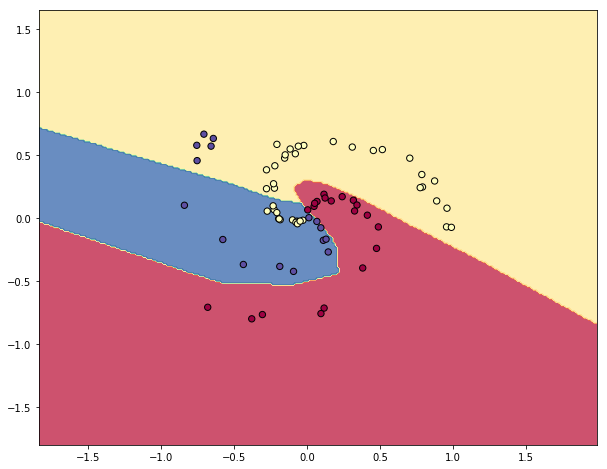

---------- Epoch: 20 ----------
Accuracy: Training Set  : 97.00%
Accuracy: Validation Set: 89.00%


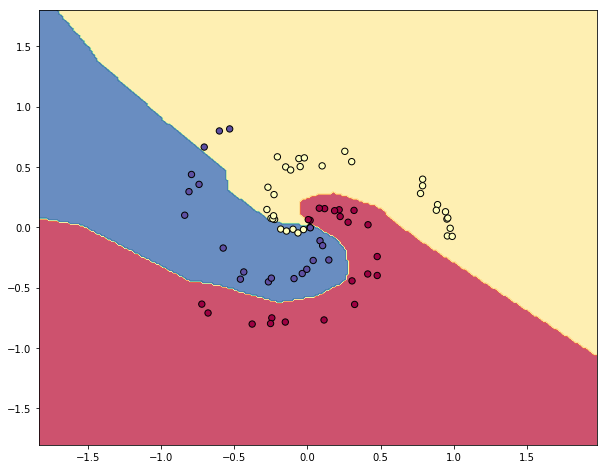

---------- Epoch: 30 ----------
Accuracy: Training Set  : 96.00%
Accuracy: Validation Set: 98.00%


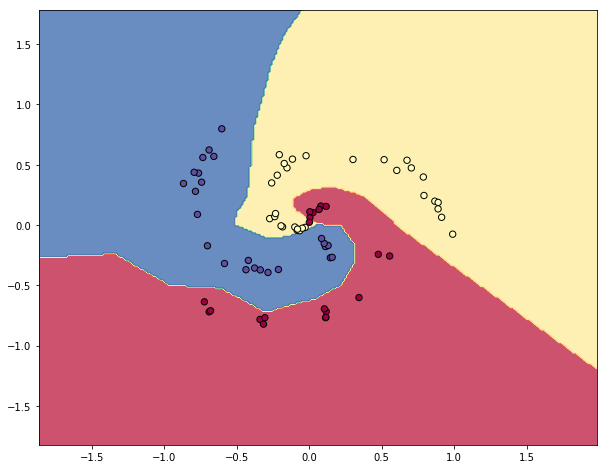

---------- Epoch: 40 ----------
Accuracy: Training Set  : 97.00%
Accuracy: Validation Set: 98.00%


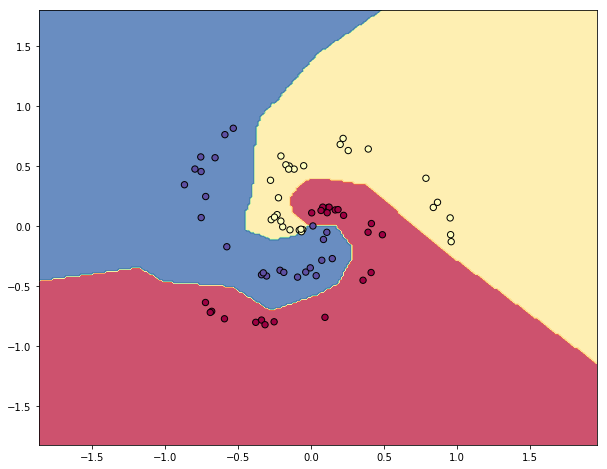

---------- Epoch: 50 ----------
Accuracy: Training Set  : 98.00%
Accuracy: Validation Set: 97.00%


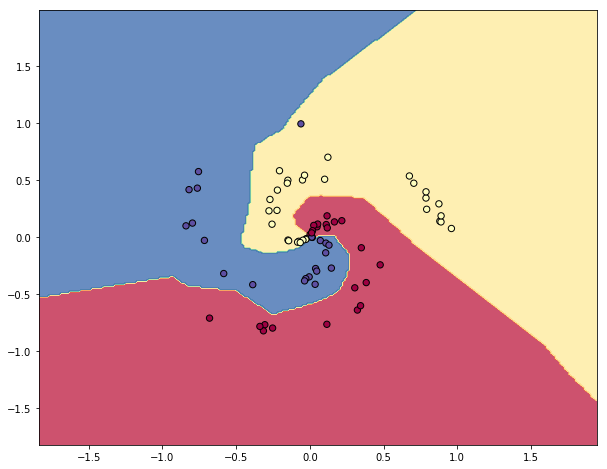

---------- Epoch: 60 ----------
Accuracy: Training Set  : 96.00%
Accuracy: Validation Set: 100.00%


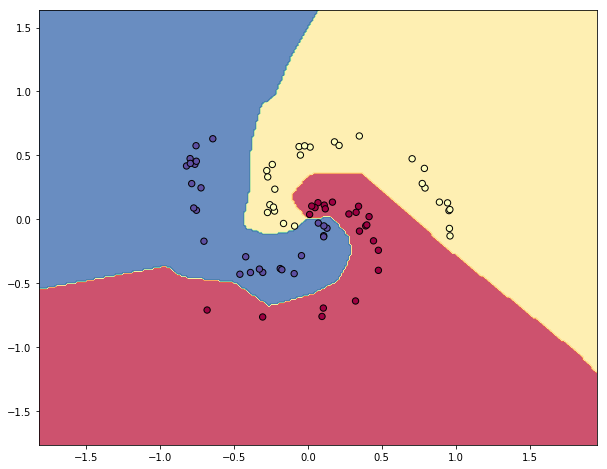

---------- Epoch: 70 ----------
Accuracy: Training Set  : 97.00%
Accuracy: Validation Set: 100.00%


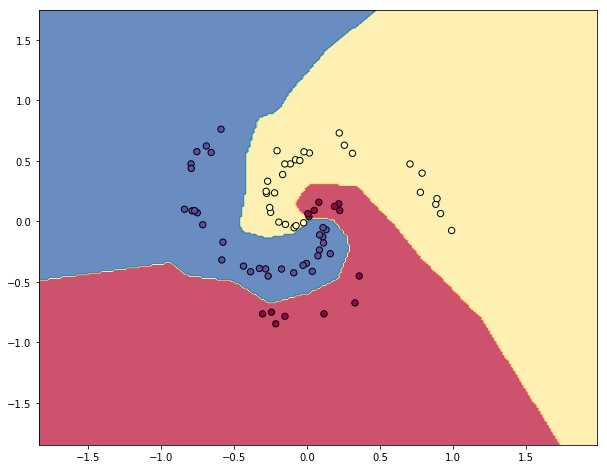

---------- Epoch: 80 ----------
Accuracy: Training Set  : 97.00%
Accuracy: Validation Set: 100.00%


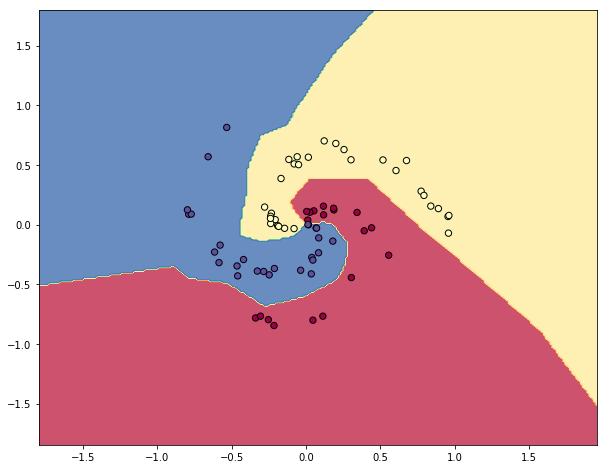

---------- Epoch: 90 ----------
Accuracy: Training Set  : 97.00%
Accuracy: Validation Set: 98.00%


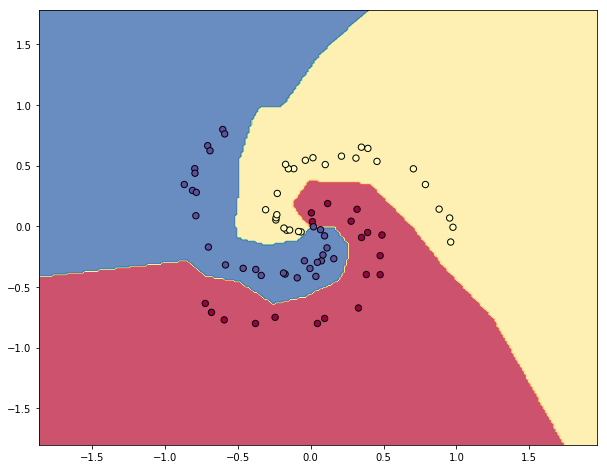

---------- Epoch: 100 ----------
Accuracy: Training Set  : 98.00%
Accuracy: Validation Set: 100.00%


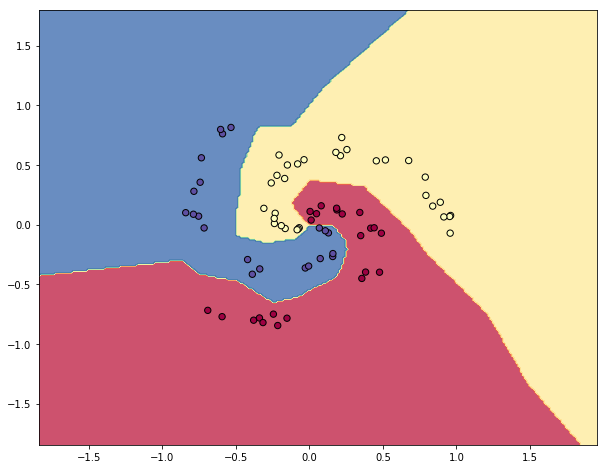

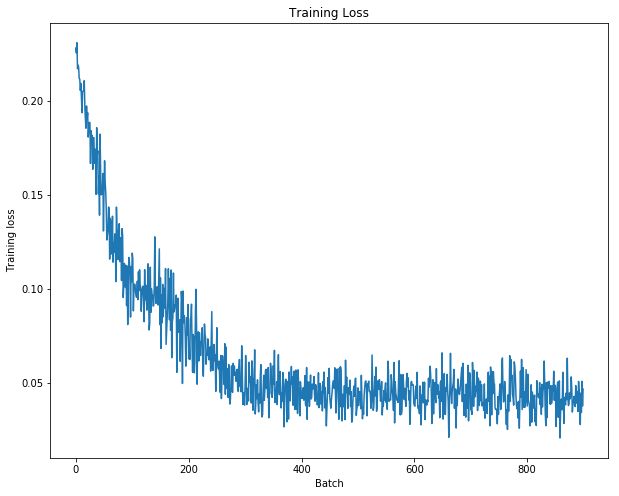

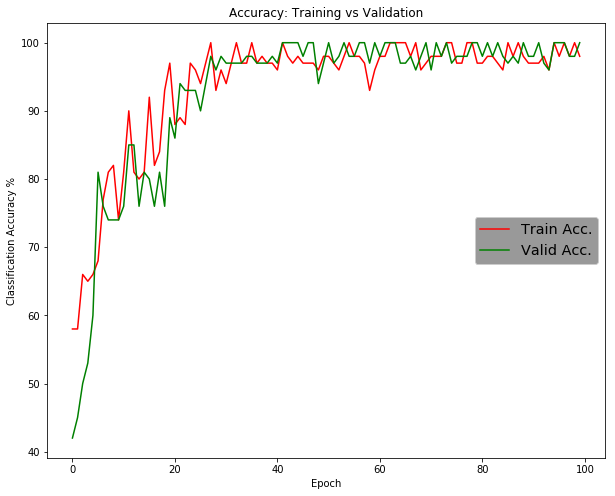

---------- Full Data Set: 900 samples ----------
Accuracy: Full Set  : 98.00%


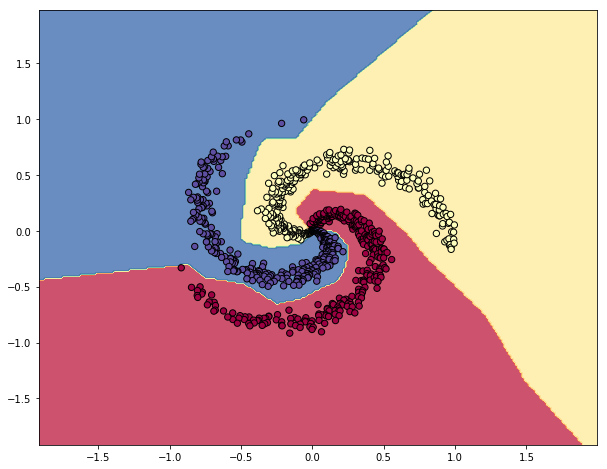

In [61]:
#import torch
from torch.utils import data

# Weight initialisation function
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

# Instantiate the model
model = NeuralNetwork(2, 3)

# Initialise weights
model.apply(init_weights)

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algoriths. The first argument to the Adam constructor tells the
# optimizer which Tensors it should update, weight_decay applies L2
# regularization to smooth the weights.
learning_rate = 1e-2
lambda_L2 = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=lambda_L2)

# Lists to gather training metrics
train_loss = []
train_acc = []
valid_acc = []


# CUDA for PyTorch
torch.backends.cudnn.benchmark = True

# Parameters
params = {'batch_size': 75,
          'shuffle': True,
          'num_workers': 8 }

# Train for ...
max_epochs = 100

# Generators
training_set = Dataset(partition['train'], labels)
training_generator = data.DataLoader(training_set, **params)

validation_set = Dataset(partition['validation'], labels)
validation_generator = data.DataLoader(validation_set, **params)

# Loop over epochs
for epoch in range(max_epochs):
    # Training
    for X_train, y_train in training_generator:
        # Transfer to GPU
        X_train, y_train = X_train.to(device), y_train.to(device)
                       
        #Set to training mode
        model.train()      
           
        # Model computations
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(X_train)

        # Compute and print loss.
        loss = loss_fn(y_pred, y_train)       

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model). This is because by default, gradients are
        # accumulated in buffers( i.e, not overwritten) whenever .backward()
        # is called. Checkout docs of torch.autograd.backward for more details.
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()
        
        # Collect the training loss value for plotting
        train_loss.append(loss.item())        
             
    # Validation at the end of each epoch
    with torch.set_grad_enabled(False):
      # Lists to gather training metrics for this batch
      batch_ta = []
      batch_va = []
      for X_valid, y_valid in validation_generator:
          #Transfer to GPU
          X_valid, y_valid = X_valid.to(device), y_valid.to(device)
          
          # Training set accuracy
          ta = check_accuracy(model, X_train, y_train)
          batch_ta.append(ta)
                    
          # Validation set accuracy
          va = check_accuracy(model, X_valid, y_valid)
          batch_va.append(va)
          
      train_acc.append(np.mean(ta))  
      valid_acc.append(np.mean(va))
      
    if (epoch + 1) % 10 == 0:
      print('---------- Epoch: {} ----------'.format(epoch + 1))
      print('Accuracy: Training Set  : {:.2f}%'.format(train_acc[-1]))           
      print('Accuracy: Validation Set: {:.2f}%'.format(valid_acc[-1]))
      # Decode the one-hot encoding e.g: [0,1,0] back to numerical values; 1
      (y_max_vals, y_arg_maxs) = torch.max(y_valid.data, dim=1)
      # Plot batch on decision boundaries so far learned
      plot_decision_boundary(model, X_valid.cpu(), y_arg_maxs.cpu())  
                
# Loss plot
fig, ax = plt.subplots()
ax.plot(train_loss)
ax.set_xlabel('Batch')
ax.set_ylabel('Training loss')
ax.set_title('Training Loss')
plt.show()

# Accuracy plot
fig1, ax1 = plt.subplots()
ax1.plot(train_acc, 'r-', label='Train Acc.')
ax1.plot(valid_acc, 'g-', label='Valid Acc.')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Classification Accuracy %')
ax1.set_title('Accuracy: Training vs Validation')
legend1 = ax1.legend(loc='center right', shadow=False, fontsize='x-large')
# Set legend background colour
legend1.get_frame().set_facecolor('0.5')
plt.show()


# Plot full data set overlayed on learned decision boundaries
print('---------- Full Data Set: {} samples ----------'.format(len(X)))
# Original data is not ohe
y_one_hot = np.eye(3)[y]
print('Accuracy: Full Set  : {:.2f}%'.format(check_accuracy(model, X,
    torch.tensor(y_one_hot, dtype=torch.float32))))
plot_decision_boundary(model, X, y)

# References

[CS231n Convolutional neural networks for visual recognition](http://cs231n.github.io/neural-networks-case-study/)

[Learning PyTorch with examples](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html)

[A detailed example of data loaders with PyTorch](https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel)